# get financial data

## import modules and difine basic modules & functions

In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import time


def defaultPlotting():
    sns.set_theme(
        rc={
            "figure.figsize": (6, 4),
            "axes.titlesize": 20,
            "axes.labelsize": 20,
            "font.size": 20,
            "legend.fontsize": 15,
        },
        style="white",
    )
    sns.set_style("whitegrid")


def today(time=False):
    if time==True:
        return datetime.today().strftime("%Y-%m-%d-%H:%M:%S")
    else:
        return datetime.today().strftime("%Y-%m-%d")

## define basic classes & functions

In [2]:
# test code
#df=get_earnings_history("SQ",verbose=False)
#display(df)

In [19]:
import os.path, time
from datetime import datetime, timedelta
from pathlib import Path

cache_dir = "cache"

def save_pickle(dfname, obj):
    if obj is None:
        obj=pd.DataFrame()

    Path(cache_dir).mkdir(parents=True, exist_ok=True)
    fname = cache_dir + "/{}.pkl".format(dfname)
    pickle.dump(obj, open(fname, "wb"))


#    df.to_pickle(fname) # if obj is a df

# check the existence of file
# arguments:
#    clear_cache: number of days of preserving cache
#                 set False if you want to use cache despite the time stamp of the file
# return value:
#    None if not exists
#    True if (cache was created within `cache_dir` days) or (cache exists and use it (clear_cache=False))
#    False otherwise
def isnewfile(dfname, clear_cache=1, verbose=False):
    fname = "{}/{}.pkl".format(cache_dir, dfname)

    if not os.path.isfile(fname):
        verbose and print("{} not found".format(fname))
        return None

    if clear_cache is False:
        verbose and print("{} is found and preserve cache".format(fname))
        return True
    
    now = datetime.utcnow()
    file_time = datetime.utcfromtimestamp(os.path.getmtime(fname))
    if (now - file_time) > timedelta(clear_cache):
        verbose and print("more than {} day has passed".format(clear_cache))
        return False
    else:
        verbose and print("you have new file within {} day".format(clear_cache))
        return True


def load_pickle(dfname):
    fname = "{}/{}.pkl".format(cache_dir, dfname)
    obj = pickle.load(open(fname, "rb"))
    return(obj)

# return
#  object if dfname is a file
#  None otherwise (no data file)
def get_df_from_file(dfname, clear_cache=1,verbose=False):
    if isnewfile(dfname, clear_cache=clear_cache, verbose=verbose):
        verbose and print("loading cache dat")
        df = load_pickle(dfname)
        return df
    else:
        verbose and print("no file found")
        return None
    
def check_ticker(ticker):
    ret=True
    try:
        si.get_company_officers(ticker)
    except:
        ret=False
    return(ret)

In [20]:
# get_earnings_history() gets actual/expected EPS history
# plot_eps() shows the result
# get_earnings_history store data in cache/ and keeps it one day
# Usage:
#   ticker=["SQ"]
#   df_earnings=get_earnings_history(ticker)
#   plot_eps(df_earnings)


# return None if no data is available
def _get_earnings_history(ticker, clear_cache=1, verbose=False):

    verbose and print("getting data of {}".format(ticker))

    dfname = ticker + "_earnings"
    df=get_df_from_file(dfname, clear_cache=clear_cache, verbose=verbose)
    if df is not None: # True if data file exists (df is empty if no data is available)
        return(df)
    
    if not check_ticker(ticker):
        print("invalid ticker name")
        return None
    
    verbose and print("getting new dat")
    dct = si.get_earnings_history(ticker)
    if len(dct) == 0:
        print("no data for {}".format(ticker))
        save_pickle(dfname=dfname, obj=None)
        return None

    df = pd.json_normalize(dct).dropna()
    if len(df) == 0:
        print("no data for {}".format(ticker))
        return None

    df["startdatetime"] = df["startdatetime"].str.replace(r"T.*$", "", regex=True)

    save_pickle(dfname=dfname, obj=df)

    return df


def get_earnings_history(tickers, clear_cache=1, verbose=False):

    if isinstance(tickers, str):
        tickers = [tickers]

    df = pd.DataFrame()
    for ticker in tickers:
        ticker = ticker.upper()
        tmp = _get_earnings_history(ticker, clear_cache=clear_cache, verbose)
        if tmp is not None and len(tmp) != 0:
            df = df.append(tmp)

    return df


def _plot_eps(df, ax, last):
    d = df.set_index("startdatetime").sort_index().tail(last)
    sns.lineplot(ax=ax, data=d[["epsactual", "epsestimate"]], marker="o")
    ax.set_title(d["ticker"][0])
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("EPS")


def plot_eps(df, last=1000, largefig=False):

    tickers = df.ticker.unique()
    n_tick = len(tickers)

    if largefig == True:
        width = 12
        height = 8
        max_col = 1
    else:
        width = 6
        height = 4
        if n_tick <= 3:
            max_col = n_tick
        elif n_tick == 4:
            max_col = 2
        elif n_tick <= 6:
            max_col = 3
        else:
            max_col = 3
    #        max_col=4

    n_tick = len(tickers)
    n_col = min(n_tick, max_col)
    n_row = (n_tick - 1) // max_col + 1
    print("ntick: {}, nrow: {}, ncol: {}".format(n_tick, n_row, n_col))

    defaultPlotting()
    fig, axes = plt.subplots(n_row, n_col, figsize=(width * n_col, height * n_row))
    fig.suptitle("EPS history within last {} quarters ({})".format(last, today()))

    for i, ticker in enumerate(tickers):
        target = df[df["ticker"] == ticker]

        if n_row == 1 or n_col == 1:
            ax = axes if n_tick == 1 else axes[i]
        else:
            row = i // n_col
            col = i % n_col
            ax = axes[row, col]

        _plot_eps(target, ax, min(last, len(target)))

    fig.tight_layout()
    plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-20-d0c8cf7162f9>, line 51)

In [21]:
# get_financial_data() calls si.get_quote_table() and si.get_stats_valuation(), and combine the results
# plot_financials() shows a plot of the data from get_financial_data()
# Usage:
#   df=get_financial_data(tickers)
#   res=plot_financials(df, table=True)


def _get_financial_data(ticker, clear_cache=1, verbose=False):
    dfname = ticker + "_financial"
    df = get_df_from_file(dfname, clear_cache=clear_cache, verbose=verbose)
    if df is not None: # True if data file exists (df is empty if no data is available)
        return(df)
    
    if not check_ticker(ticker):
        print("invalid ticker name")
        return None    
        
    verbose and print("getting new financial dat")
    dct_qt = si.get_quote_table(ticker)
    df_qt = (
        pd.json_normalize(dct_qt)
        .transpose()
        .reset_index()
        .set_axis(["info", "values"], axis=1)
    )

    df_val = si.get_stats_valuation(ticker).set_axis(["info", "values"], axis=1)

    df = pd.concat([df_qt, df_val], ignore_index=True).sort_values(by="info")
    df["Ticker"] = ticker
    save_pickle(dfname=dfname, obj=df)

    return df


def get_financial_data(tickers, clear_cache=1, verbose=False):
    if isinstance(tickers, str):
        tickers = [tickers]

    data = pd.DataFrame(index=[], columns=["Ticker", "info", "values"])
    for ticker in tickers:
        ticker = ticker.upper()
        tmp = _get_financial_data(ticker, clear_cache=clear_cache, verbose=verbose)
        if tmp is not None and len(tmp) != 0:
            data = data.append(tmp, ignore_index=True)

    df = data.pivot(index="Ticker", columns="info", values="values")
    return df


def col_name(df, str):
    return [col for col in df.columns if str in col]


def plot_financials(df, table=False):

    PSR = col_name(df, "Price/Sales")
    PBR = col_name(df, "Price/Book")
    PER = col_name(df, "PE Ratio")
    EPS = col_name(df, "EPS")
    Target = col_name(df, "Target")
    Cap = ["Market Cap"]
    Date = col_name(df, "Earnings Date")
    Dividend = col_name(df, "Forward Dividend")
    Price = col_name(df, "Close")

    #    numeric=Price+Target+PSR+PER+PBR+EPS
    numeric = Price + Target + PSR + PER + PBR
    df[numeric] = df[numeric].astype("float")

    #     df[PSR].plot(kind="hist",bins=20)
    #     plt.xlabel("PSR")
    #     plt.show()

    defaultPlotting()
    ax = sns.histplot(data=df[PSR], bins=20).set_title(
        "PSR histogram ({})".format(today())
    )
    plt.xlabel("PSR")
    plt.show()

    target = Cap + numeric + Date
    df_tgt = df[target].sort_values(by=PSR, ascending=False)

    if table == True:
        print("PSR sorted list ({})".format(today))
        display(df_tgt)
    else:
        print("The top 5 PSR stocks ({})".format(today))
        display(df_tgt.head())

    return df_tgt

## Ticker list of stock indexes

In [6]:
# get ticker list
tickers_dow = si.tickers_dow()
tickers_nasdaq = si.tickers_nasdaq()
tickers_sp500 = si.tickers_sp500()
tickers_other = si.tickers_other()

print(len(tickers_dow))
print(len(tickers_nasdaq))
print(len(tickers_sp500))
print(len(tickers_other))

30
4849
505
6085


## Get data! It takes a while, so please be patient!

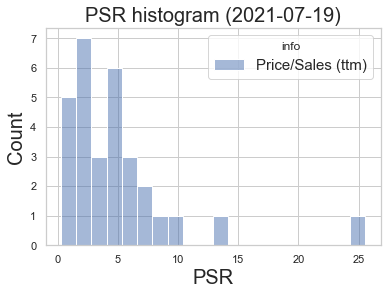

The top 5 PSR stocks (<function today at 0x7fdaa9a999d0>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
V,545.956B,248.55,268.97,25.57,51.29,15.43,"Jul 27, 2021"
MSFT,2.114T,281.03,298.92,13.22,38.26,15.73,"Jul 27, 2021"
CRM,220.786B,237.58,278.66,9.88,50.27,5.18,"Aug 23, 2021 - Aug 27, 2021"
MCD,175.164B,236.88,258.34,8.93,34.07,NaN,"Jul 28, 2021"
AAPL,2.443T,148.48,159.34,7.51,32.90,35.31,"Jul 28, 2021 - Aug 02, 2021"


In [22]:
# get data of stock indexes
df_dow = get_financial_data(tickers=tickers_dow)
df_dow_final=plot_financials(df_dow,table=False)
# df_nasdaq=get_financial_data(tickers=tickers_nasdaq)
# df_sp500=get_financial_data(tickers=tickers_sp500)

## Get stock info of your favorite
### EPS beat ratio が高いTickerを見つける

In [13]:
# show_beat_ratio(): EPS beat ratioの一覧作成
# Arguments:
#   last=20      # # of quarters to be considered 
#   threshold=80 # if you want to show only beatratio > 80%
# Usage:
#   df_eps=get_earnings_history(ticker)
#   show_beat_ratio(df_eps)
#

def show_beat_ratio(
    df, last=20, threshold=False, min_qtrs=1, verbose=False
):
    group = ["ticker", "companyshortname"]
    target = (
        df[["startdatetime", "ticker", "epssurprisepct", "companyshortname"]]
        .dropna()
        .set_index("startdatetime")
        .sort_index()
        .groupby(group)
        .tail(last)
    )
    target["beat"] = target["epssurprisepct"] >= 0
    if verbose: display(target)
        
    ratio = target.groupby(group).mean().rename(columns={"beat": "beat ratio"})
    count = (
        target.groupby(group)
        .count()
        .drop("epssurprisepct", axis=1)
        .rename(columns={"beat": "count"})
    )
    if verbose: display(count)
    
    beat = target.groupby(group).sum().drop("epssurprisepct", axis=1)

    result = ratio.join(count)
    result = result.join(beat).sort_values(by="beat ratio", ascending=False)
    result["beat ratio"] = result["beat ratio"] * 100
    if verbose: display(target)
    
    if threshold == False:
        print("EPS beat ratio (%) within last {} quarters ({})".format(last, today()))
    else:
        print(
            "Tickers list of which beat ratio >= {} % within last {} quarters".format(
                threshold, last, today()
            )
        )
        print("(data with more than {} quarter EPSs)".format(min_qtrs))
        result = result[ (result["beat ratio"] >= threshold) & (result["count"] >= min_qtrs)]

    return result[["beat ratio", "beat", "count"]]


# get_all_data(): get_earnings_history()とget_financial_data()の結果を返す。ついでに EPS beat ratioの一覧表示
def get_all_data(ticker, last=20):
    # get eps history
    df_earnings = get_earnings_history(ticker)
    # get PSR and others
    df_ticker = get_financial_data(ticker)

    display(show_beat_ratio(df_earnings, last))
    return (df_earnings, df_ticker)

In [14]:
# search_good_eps(): Search Tickers of which EPS beat ratio is larger than a threshold
def search_good_eps(tickers, last=20, threshold=80, min_qtrs=4, clear_cache=False, verbose=False):

    n_tick = len(tickers)
    step = 10
    i = 0
    df = pd.DataFrame()
    while i < n_tick:
        end = min(i + step, n_tick)
        df_new = get_earnings_history(tickers[i:end], clear_cache, verbose=verbose)
        if len(df_new) != 0:
            df = df.append(df_new)
        i = i + step
        time.sleep(60)

    df_best = show_beat_ratio(df, last=last, threshold=threshold, min_qtrs=min_qtrs)
    display(df_best)
    return df

In [24]:
# pd.set_option('display.max_rows', df.shape[0]+1)

#nas500=search_good_eps(tickers=tickers_nasdaq[0:400],last=20,threshold=90,verbose=False)
#save_pickle('nas400_eps',nas400)
#target='nas400_eps'
#nas400 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
#print(len(nas400.ticker.unique()))
show_beat_ratio(nas400,last=40,threshold=95,min_qtrs=20)

#nas200_best = pickle.load( open( "data/nas200_best.pkl", "rb" ) )

#nas100=search_good_eps(tickers=tickers_nasdaq[0:100],last=20,threshold=80,verbose=False)
#save_pickle('nas100_eps',nas100)


NameError: name 'nas400' is not defined

ntick: 1, nrow: 1, ncol: 1


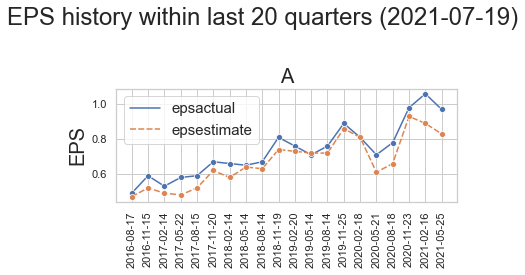

In [25]:
df=get_earnings_history("A")
plot_eps(df,last=20,largefig=False)

In [135]:
#target="nas400_eps"
#nas400 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )

#df=pd.concat([nas200,nas400,nas600,nas1000])
#save_pickle('nas1000_eps',df)
target="nas1000_eps"
nas1000 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )

print(len(nas1000.ticker.unique()))

#display(df)
#show_beat_ratio(nas1000,last=20,threshold=95,min_qtrs=4)
show_beat_ratio(nas1000,last=20,threshold=95,min_qtrs=4)

596
Tickers list of which beat ratio >= 95 % within last 20 quarters
(data with more than 4 quarter EPSs)


,,beat ratio,beat,count
ticker,companyshortname,,,
AEHL,Antelope Enterprise Holdings Limited,100.0,6,6
AMBA,"Ambarella, Inc.",100.0,20,20
CHKP,Check Point Software Technologies Ltd.,100.0,20,20
CHNG,Change Healthcare Inc.,100.0,8,8
BAND,Bandwidth Inc.,100.0,15,15
ALRM,"Alarm.com Holdings, Inc.",100.0,20,20
CARG,"CarGurus, Inc.",100.0,14,14
BL,"BlackLine, Inc.",100.0,19,19
API,"Agora, Inc.",100.0,4,4


In [125]:
#df = pickle.load( open( "data/nas200_eps.pkl", "rb" ) )
#display(df[:10])
#show_beat_ratio(df,last=20,threshold=95,min_qtrs=4)


'AEHR'

## Tech

In [42]:
fangam=["FB","AAPL","NFLX","GOOG","AMZN","MSFT"]

###
ant=["ADBE","NVDA","TSLA"]
saas=["CRWD","OKTA","ZS","TTD","TWLO"]
ecommerce=["SHOP","ETSY","FIVN"]

fintech=["SQ","DOCU"]
media=["TWTR","PINS"]
techs=["U","ZM","FVRR","ABNB","ROKU"]

growth1=ant+saas+ecommerce
growth2=fintech+media+techs

###
eauto=["F","GM","MGA"]

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
AAPL,Apple Inc.,100.0,20,20
MSFT,Microsoft Corporation,100.0,20,20
AMZN,"Amazon.com, Inc.",75.0,15,20
FB,"Facebook, Inc.",75.0,15,20
GOOG,Alphabet Inc.,70.0,14,20
NFLX,"Netflix, Inc.",65.0,13,20


ntick: 6, nrow: 2, ncol: 3


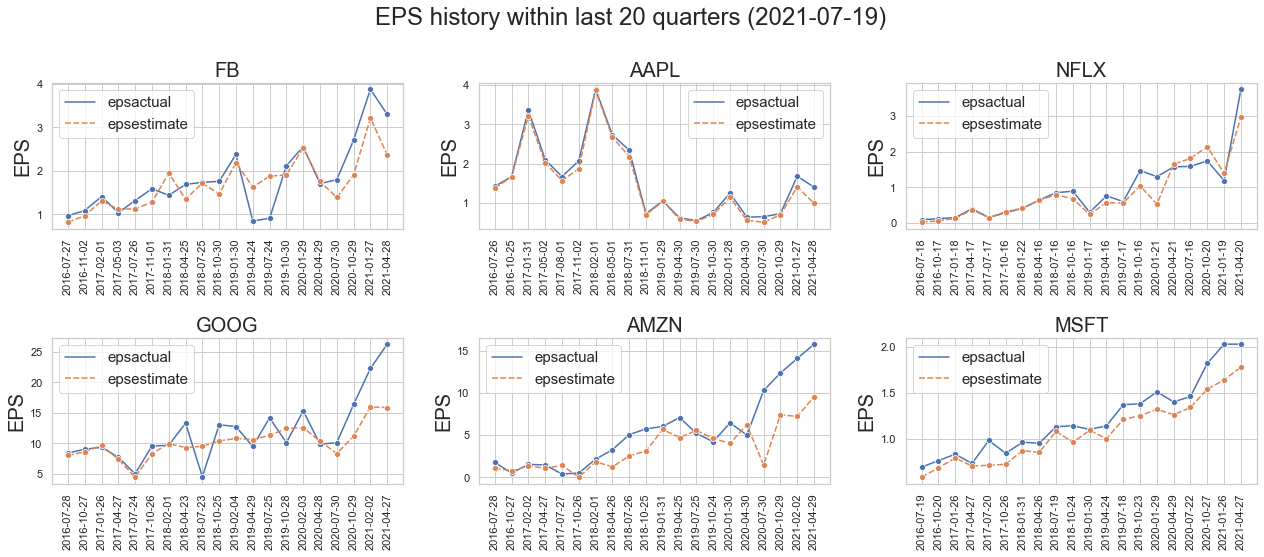

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
CRWD,"CrowdStrike Holdings, Inc.",100.0,9,9
FIVN,"Five9, Inc.",100.0,20,20
OKTA,"Okta, Inc.",100.0,17,17
TTD,"The Trade Desk, Inc.",100.0,19,19
ZS,"Zscaler, Inc.",100.0,13,13
ADBE,Adobe Inc.,95.0,19,20
NVDA,NVIDIA Corporation,95.0,19,20
SHOP,Shopify Inc.,95.0,19,20
TWLO,Twilio Inc.,90.0,18,20


ntick: 11, nrow: 4, ncol: 3


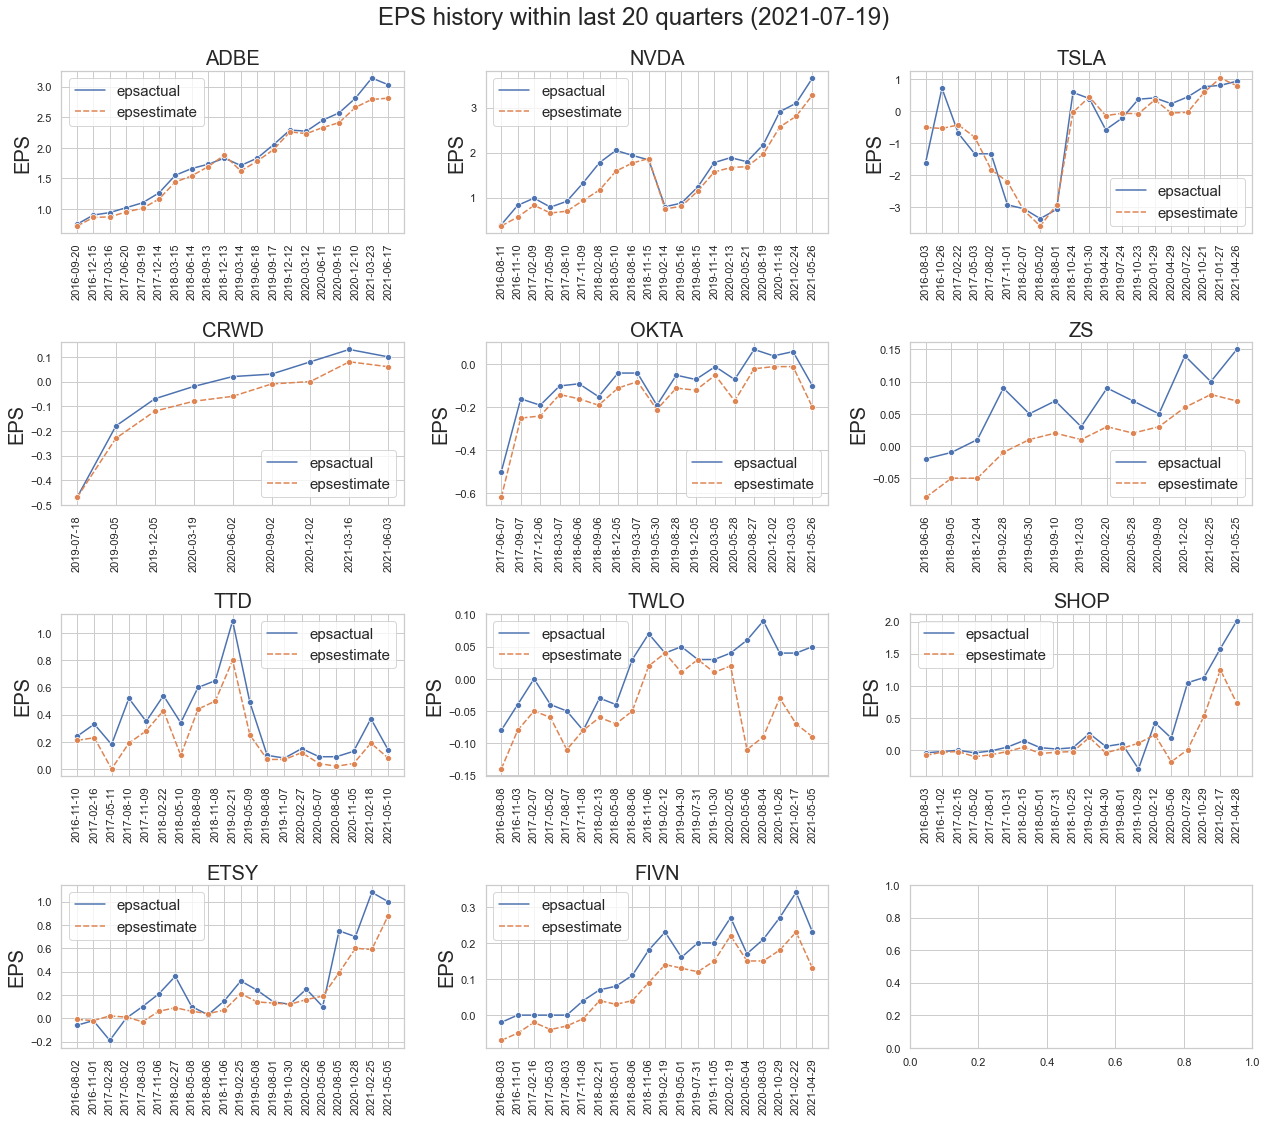

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
U,Unity Software Inc.,100.000000,3,3
ZM,"Zoom Video Communications, Inc.",100.000000,9,9
SQ,"Square, Inc.",95.000000,19,20
DOCU,"DocuSign, Inc.",92.307692,12,13
FVRR,Fiverr International Ltd.,87.500000,7,8
ROKU,"Roku, Inc.",86.666667,13,15
TWTR,"Twitter, Inc.",85.000000,17,20
PINS,"Pinterest, Inc.",77.777778,7,9
ABNB,"Airbnb, Inc.",0.000000,0,2


ntick: 9, nrow: 3, ncol: 3


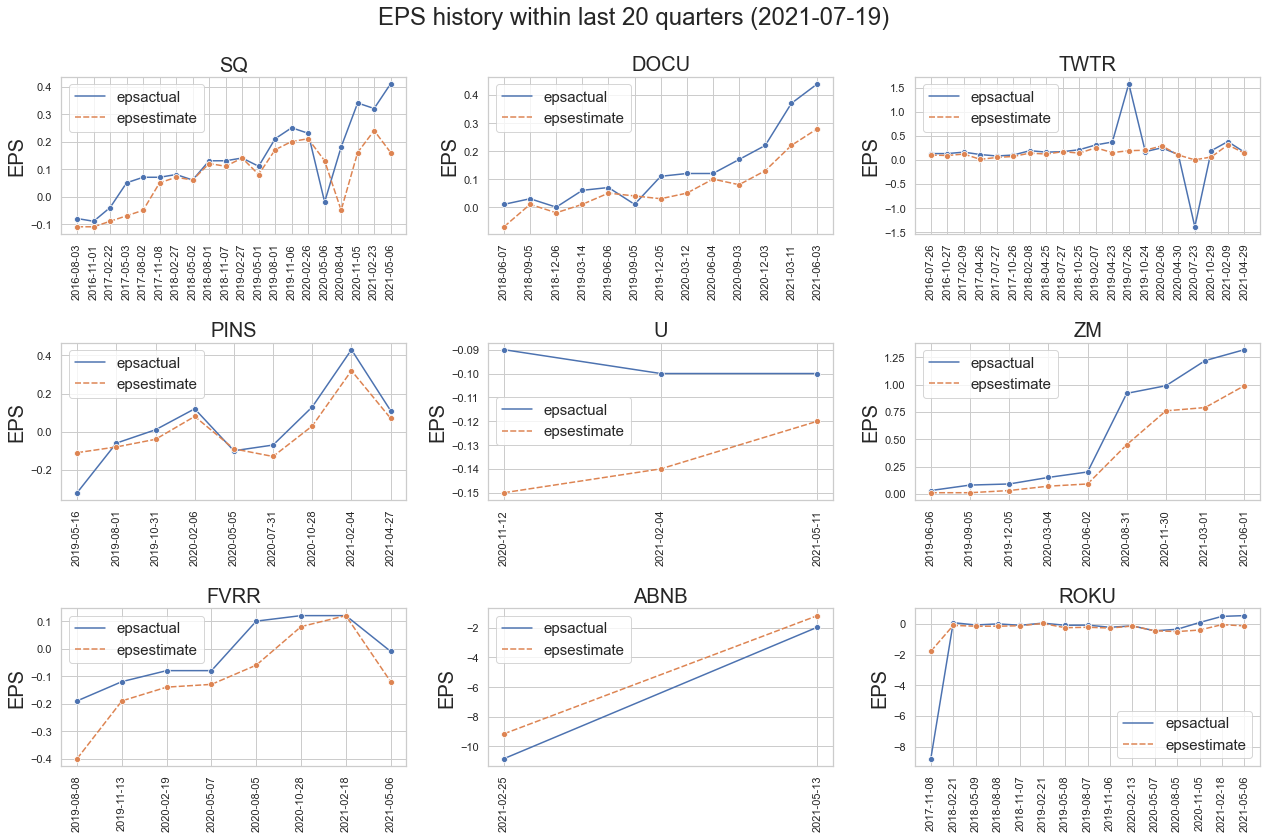

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
GM,General Motors Company,100.0,20,20
MGA,Magna International Inc.,80.0,16,20
F,Ford Motor Company,60.0,12,20


ntick: 3, nrow: 1, ncol: 3


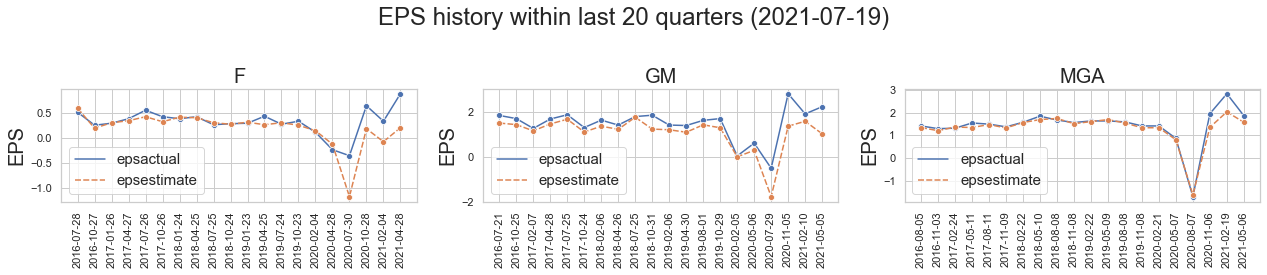

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
AAPL,Apple Inc.,100.000000,20,20
FIVN,"Five9, Inc.",100.000000,20,20
ZM,"Zoom Video Communications, Inc.",100.000000,9,9
U,Unity Software Inc.,100.000000,3,3
TTD,"The Trade Desk, Inc.",100.000000,19,19
OKTA,"Okta, Inc.",100.000000,17,17
GM,General Motors Company,100.000000,20,20
MSFT,Microsoft Corporation,100.000000,20,20
ZS,"Zscaler, Inc.",100.000000,13,13


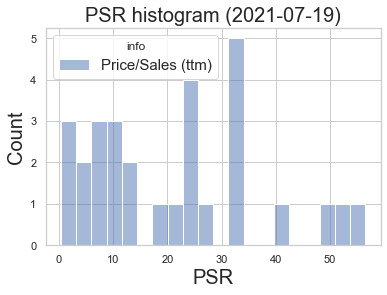

PSR sorted list (<function today at 0x7fdaa9a999d0>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
CRWD,56.444B,249.30,260.54,56.49,NaN,66.44,"Aug 31, 2021 - Sep 06, 2021"
SHOP,179.727B,1441.50,1515.09,52.12,112.81,19.62,"Jul 28, 2021"
ZS,30.296B,219.31,235.35,50.33,NaN,59.58,"Sep 07, 2021 - Sep 13, 2021"
OKTA,36.069B,237.58,276.45,39.92,NaN,45.76,"Aug 25, 2021 - Aug 30, 2021"
DOCU,54.875B,277.01,276.17,33.77,NaN,166.99,"Sep 01, 2021 - Sep 06, 2021"
FVRR,7.318B,209.79,258.88,32.72,NaN,21.57,"Aug 05, 2021"
ZM,106.653B,356.81,415.48,32.52,124.82,25.43,"Aug 30, 2021 - Sep 03, 2021"
U,27.022B,96.75,123.05,32.16,NaN,13.38,"Aug 10, 2021"
TWLO,63.433B,366.27,460.79,31.93,NaN,6.25,"Aug 02, 2021 - Aug 06, 2021"


In [43]:
df_fangam=get_all_data(fangam)
#"target='df_fangam'
# save_pickle(target,df_fangam)
#df_fangam = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_fangam[0],last=20)

# growth1
df_growth1=get_all_data(growth1)
#target='df_growth1'
#save_pickle(target,df_growth1)
#df_growth1 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_growth1[0],last=20)

# growth2
df_growth2=get_all_data(growth2)
#target='df_growth2'
#save_pickle(target,df_growth2)
#df_growth2 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_growth2[0],last=20)

# eauto
df_eauto=get_all_data(eauto)
#target='df_eauto'
#save_pickle(target,df_eauto)
#df_eauto = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_eauto[0],last=20)

df_all=pd.concat([df_fangam[0],df_growth1[0],df_growth2[0],df_eauto[0]])
display(show_beat_ratio(df_all, last=20))

# all PSR
df_all_psr=pd.concat([df_fangam[1],df_growth1[1],df_growth2[1],df_eauto[1]])
df_res=plot_financials(df_all_psr, table=True)

## FANGAMのみ大きく出してみる

ntick: 6, nrow: 6, ncol: 1


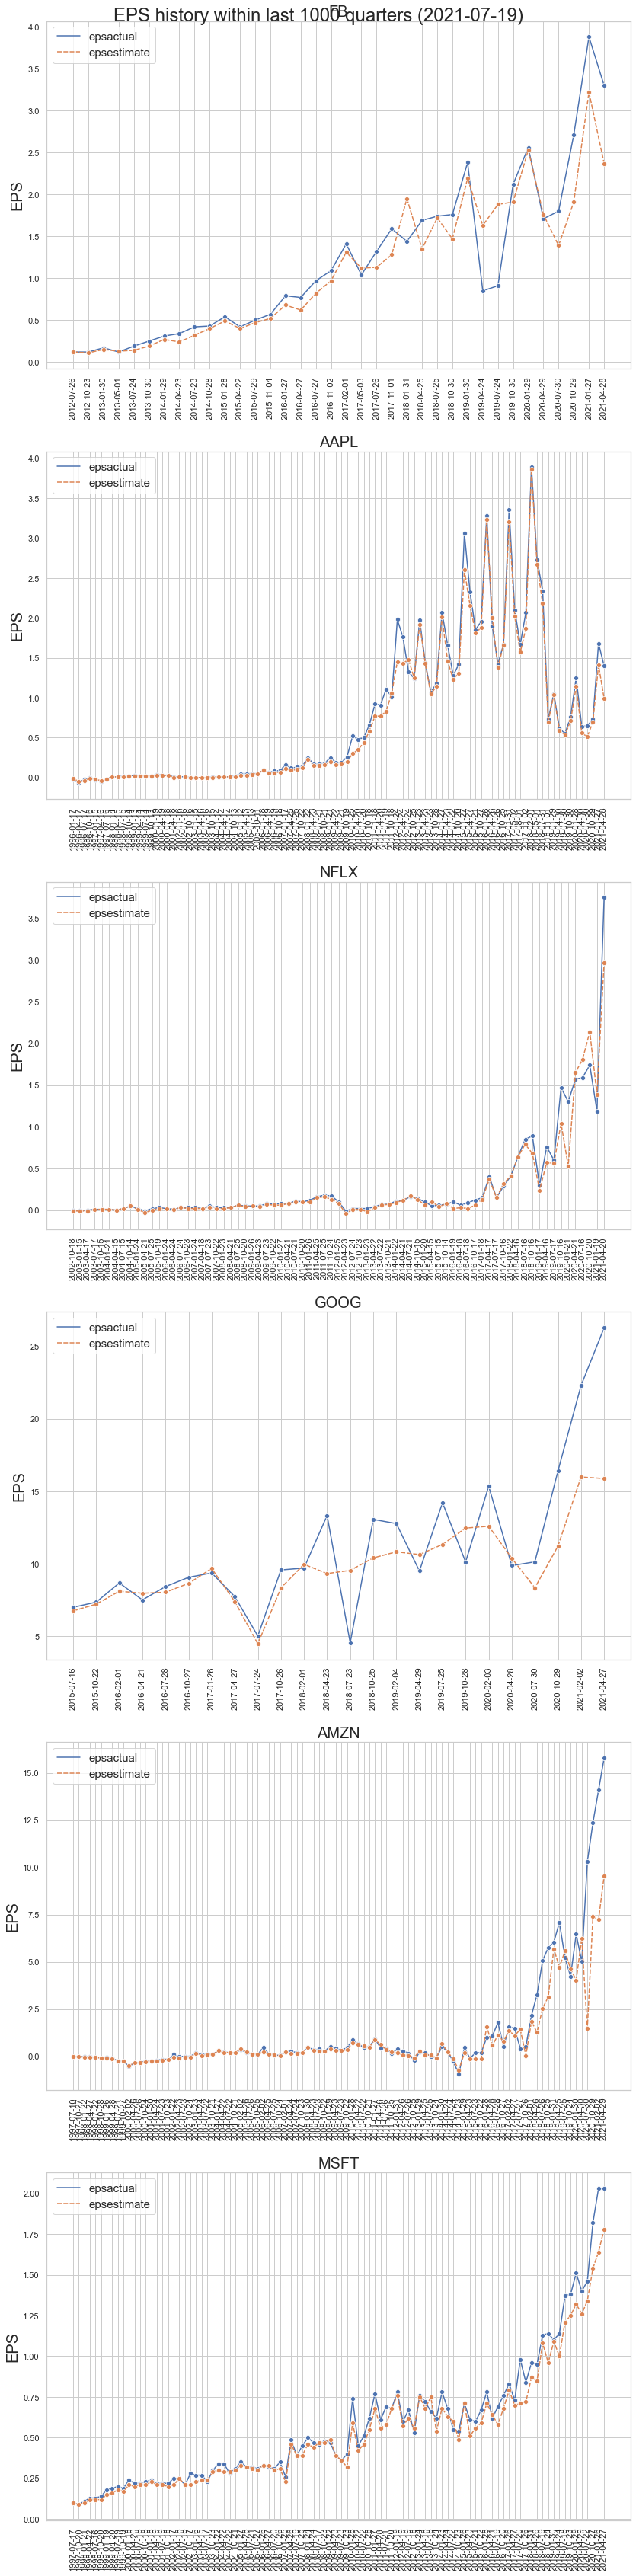

EPS beat ratio (%) within last 200 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
AAPL,Apple Inc.,89.583333,86,96
MSFT,Microsoft Corporation,87.500000,84,96
FB,"Facebook, Inc.",83.333333,30,36
NFLX,"Netflix, Inc.",81.333333,61,75
AMZN,"Amazon.com, Inc.",76.041667,73,96
GOOG,Alphabet Inc.,70.833333,17,24


In [33]:
plot_eps(df_fangam[0],largefig=True)
show_beat_ratio(df_fangam[0], last=200)

## Health

In [34]:
tickers_health=["A","AMGN","ANTM","BMY","BNTX","BIIB","MRNA","PGNY","PFE","RPRX","VEEV"]

EPS beat ratio (%) within last 20 quarters (2021-07-19)


,,beat ratio,beat,count
ticker,companyshortname,,,
VEEV,Veeva Systems Inc.,100.000000,20,20
A,"Agilent Technologies, Inc.",95.000000,19,20
AMGN,Amgen Inc.,90.000000,18,20
BIIB,Biogen Inc.,90.000000,18,20
ANTM,"Anthem, Inc.",85.000000,17,20
BMY,Bristol-Myers Squibb Company,85.000000,17,20
PFE,Pfizer Inc.,80.000000,16,20
PGNY,"Progyny, Inc.",71.428571,5,7
MRNA,"Moderna, Inc.",60.000000,6,10


ntick: 11, nrow: 4, ncol: 3


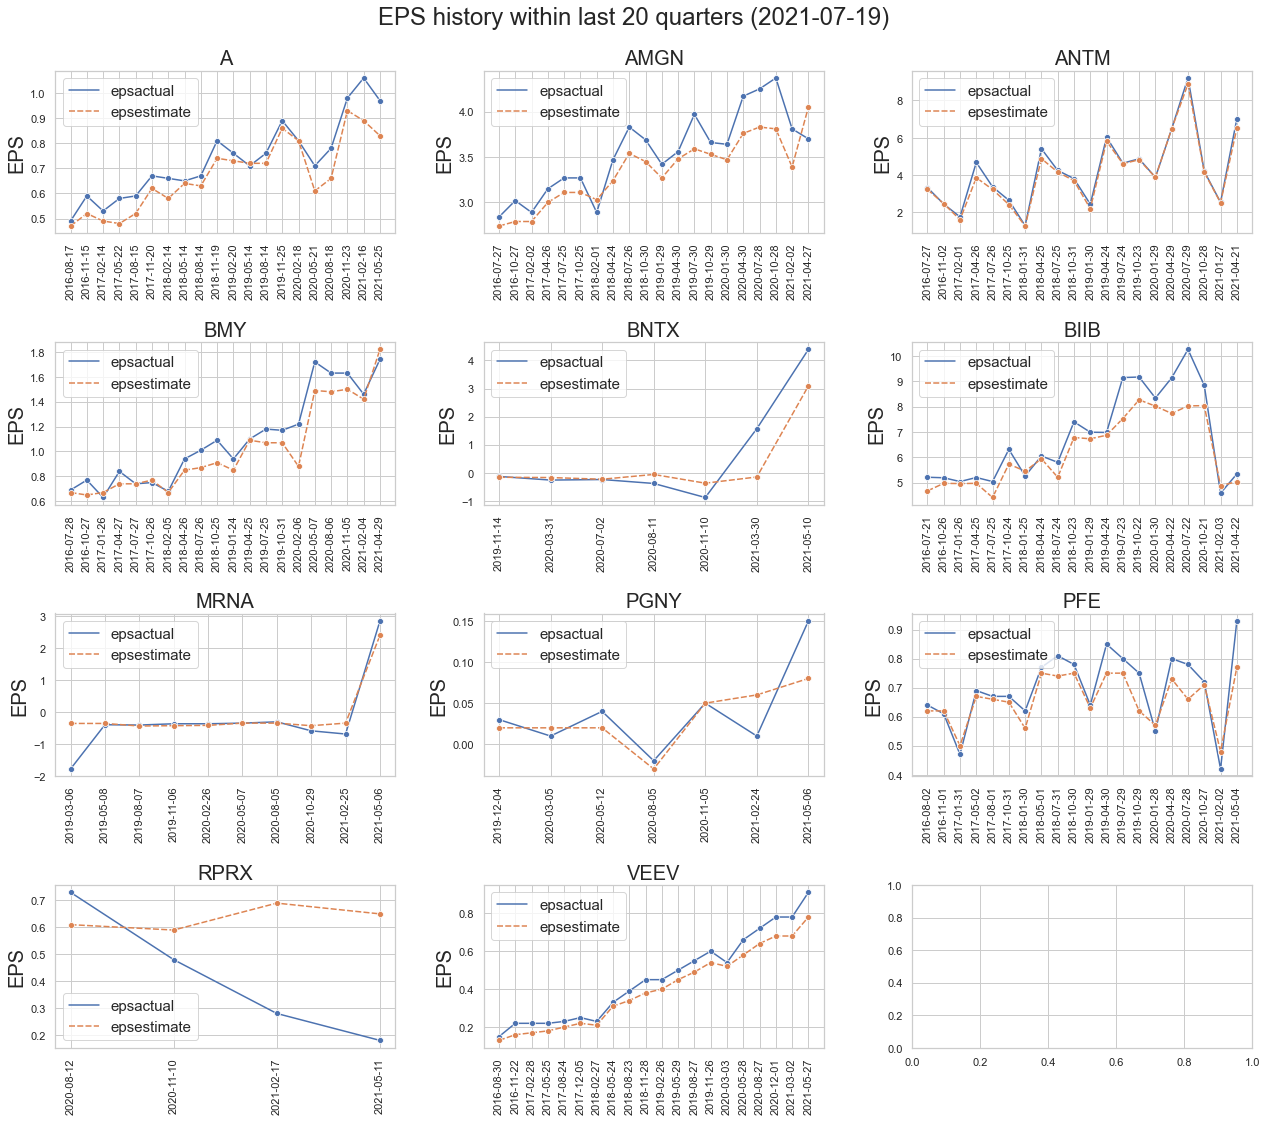

EPS beat ratio (%) within last 20 quarters (2021-07-19)


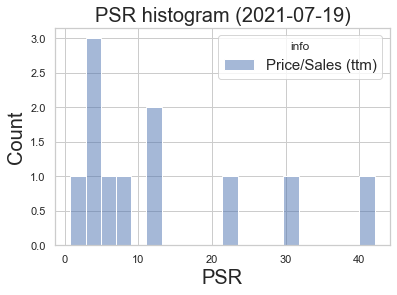

PSR sorted list (<function today at 0x7fdaa9a999d0>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
MRNA,115.01B,259.67,184.92,42.09,191.98,29.93,"Aug 03, 2021 - Aug 09, 2021"
VEEV,48.231B,312.92,333.14,30.89,124.66,19.71,"Aug 25, 2021 - Aug 30, 2021"
BNTX,55.905B,221.08,195.09,22.33,NaN,NaN,"Aug 09, 2021"
PGNY,4.748B,55.17,66.33,12.30,NaN,NaN,"Aug 03, 2021 - Aug 09, 2021"
RPRX,24.618B,40.08,52.71,11.22,NaN,NaN,"May 11, 2021"
A,45.192B,148.96,148.94,7.77,49.81,9.39,"Aug 17, 2021"
AMGN,142.466B,246.63,254.96,5.66,20.54,15.28,"Aug 03, 2021"
PFE,225.867B,40.09,42.97,4.87,20.44,3.29,"Jul 26, 2021 - Jul 30, 2021"
BIIB,48.873B,328.16,404.08,3.88,16.83,4.58,"Jul 20, 2021 - Jul 26, 2021"


In [35]:
# EPS history
df_health_eps,df_health_fin=get_all_data(tickers_health)
plot_eps(df_health_eps,last=20)
show_beat_ratio(df_health_eps)

df_res=plot_financials(df_health_fin,table=True)

## Pyfolioによる情報表示

- [pyfolio](https://github.com/quantopian/pyfolio)

```bash
$ pip install pyfolio
```

## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)
- [pyfolioを使ってみる](https://qiita.com/mrsn28/items/445553c24861b9930682)

In [581]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/jun/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [582]:
stock_rets = pf.utils.get_symbol_rets('DOCU')
#pf.create_returns_tear_sheet(stock_rets, live_start_date='2015-12-1')
pf.create_returns_tear_sheet(stock_rets)

AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'